# Introduction

Cet exercice va vous permettre de vous familiariser avec le concept de stacking sur un dataset que vous connaissez déjà, il s'agit du dataset Titanic

On commencera par importer les librairies nécessaires.

In [1]:
! pip install xgboost
! pip install plotly

In [2]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Feature Exploration, Engineering and Cleaning 

1. afficher les premières lignes du dataset

In [3]:
training_file_path = "train.csv"
testing_file_path = "test.csv"
df_train = pd.read_csv(training_file_path, index_col = [0])
df_test = pd.read_csv(testing_file_path, index_col = [0])
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


2. A quels types de variables avez vous affaire, quels types de traitements pourriez vous faire afin de créer un dataset compatible avec un modèle de ML.
Appliquez les méthodes de preprocessing choisies.

3. Si l'inspiration vous manque, voici quelques idées de nettoyage et création de variables.

a. créez une variable Name_length qui contient la longueur de la variable Name

b. Créez une variable Has_Cabin qui indique si oui ou non le passager possède une cabine.

In [5]:
df_train["HasCabin"] = 1
df_train.loc[df_train["Cabin"].isnull(),"HasCabin"] = 0

c. Créez une variable FamilySize qui donne la taille de la famille des passagers

In [6]:
df_train["FamilySize"] = df_train["SibSp"] + df_train["Parch"] + 1

d. Créez une variable IsAlone qui indique si le passager a des membres de sa famille à bord ou non.

In [7]:
df_train["isAlone"] = (df_train["FamilySize"] == 1).astype(int)

e. Remplacez les valeurs manquantes de la variables Embarked

f. Remplacez les valeurs manquantes de Fare par la médiane. Vous pouvez utiliser une méthode plus judicieuse si vous le souhaitez.

In [9]:
df_train["Fare"] = df_train.groupby(["Ticket"])["Fare"].transform(lambda x: x/x.count())
df_train["Fare"] = df_train.groupby(["Pclass"])["Fare"].transform(lambda x: x.fillna(x.median()))

g. Créez une variable CategoricalFare grâce à la fonction pd.qcut afin de produire 4 tranches.

h. Remplacez les valeurs manquantes pour l'âge grâce à la technique de votre choix.

i. Créez une variable CategoricalAge qui correspond à 5 tranches d'âge

j. Grâce à la fonction suivante re.search(' ([A-Za-z]+)\.', name) extrayez le titre de chaque passager afin de créer une variable Title

k. Est ce que certains titres sont très sous-représentés par rapport aux autres ? Si c'est le cas, remplacez ces valeurs par une catégorie unique "Rare"

l. Si certains titres sont équivalents convertissez les tous dans une seule catégories, par exemple Mlle = Miss, donc on peut remplacer tout les Mlle par Miss

m. Convertissez la variable Sex au format numérique

n. Convetissez la variable Title au format numérique

o. Convertissez la variable Embarked au format numérique

p.Créez une variable FareCategorical comme la transformée de Fare en 4 catégories.

4. Supprimez les colonnes 'PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp' du dataset, pourquoi n'en avons nous plus besoin par la suite ?

## Visualisations 

Maintenant que nous avons nettoyé le dataset lançons nous dans la visualisation de nos données.

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title,FareCategorical
0,0,3,1,22,0,7.2500,0,23,0,2,0,0,1,1,0
1,1,1,0,38,0,71.2833,1,51,1,2,0,3,2,3,3
2,1,3,0,26,0,7.9250,0,22,0,1,1,1,1,2,1


**Pearson Correlation Heatmap**

5. Générez une figure qui contient le tableau des corrélations entre les différentes variables du dataset, quelles sont vos interprétations?

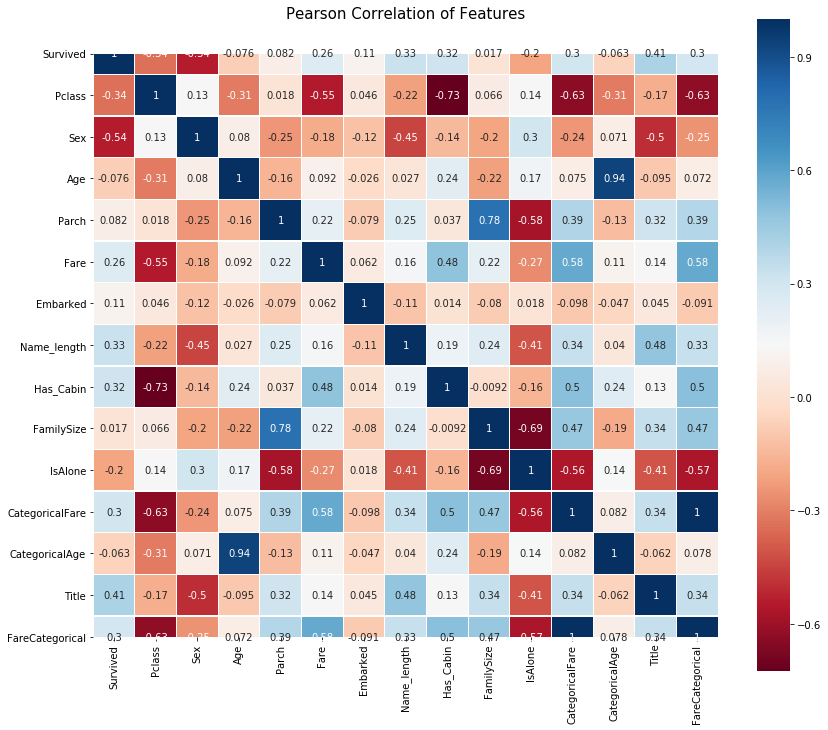

Les corrélations entre les variables explicatives ne sont pas trop élevées, nous pouvons donc espérer qu'elles apporteront chacune des informations complémentaire pour entraîner un modèle.

**Pairplots**

6. Générez des pairplots entre différentes variables explicatives afin de comprendre mieux les liens qui existent entre elles.

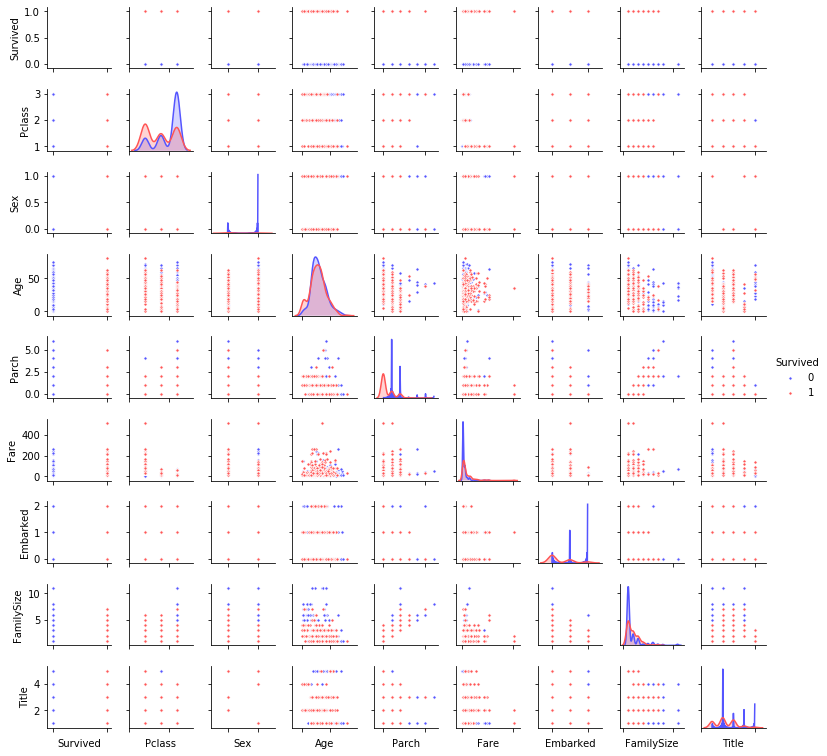

# Ensembling & Stacking models

Maintenant que nous avons avancé dans le preprocessing et la création de variables nous pouvons commencer à préparer notre modèle de stacking.

# Generating our Base First-Level Models 

Nous allons maintenant préparer les modèles de la première couche de notre stacking!

 1. Random Forest classifier
 2. Extra Trees classifier
 3. AdaBoost classifer
 4. Gradient Boosting classifer
 5. Support Vector Machine

 7. Créez une instance rf de RandomForestClassifier

8. Créez une instance d'un ExtraTreeClassifier

9. Créez une instance d'AdaboostClassifier

10. Créez une instance de GradientBoostingClassifier

11. Créez une instance de SVC

12. A partir de l'objet data, créez quatre objets x_train, x_test, y_train et y_test en vue d'entraîner nos modèles de la première couche.
On séparera également x_train et y_train en deux parties x_train1 y_train1 et x_train2 et y_train2, en effet la première partie servira à entraîner les modèles de la première couche (ou base models) et la deuxième partie que l'on transformera grâce aux bases models serivira à entraîner le modèle de la deuxième couche ou meta-model.
Ceci permet d'assurer l'indépendance entre les données d'entraînement des deux couches et de limiter ainsi le sur-apprentissage.

13. Entraînez les base models sur x_train1 et y_train1, contruisez les vecteurs de prédictions des 5 base models à partir de x_train2 et de x_test.

Training is complete


**Feature importances à partir des différents prédicteurs**

14. Utilisez les différents modèles afin de calculer l'importances des différentes variables.

15. créez un dataframe contenant les feature_importance de chaque variable

,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
Pclass,0.082746,0.097844,0.002,0.076993
Sex,0.226313,0.374546,0.008,0.227004
Age,0.068773,0.021553,0.206,0.137968
Parch,0.017600,0.015246,0.022,0.009429
Fare,0.111563,0.033405,0.470,0.159483
Embarked,0.018523,0.021127,0.018,0.019065
Name_length,0.103366,0.047077,0.128,0.148902
Has_Cabin,0.044358,0.088293,0.006,0.029978
FamilySize,0.056480,0.035761,0.050,0.049106
IsAlone,0.008130,0.021557,0.004,0.003151


16. Visualisez l'importance des variables via la figure qui vous semble la plus adaptée


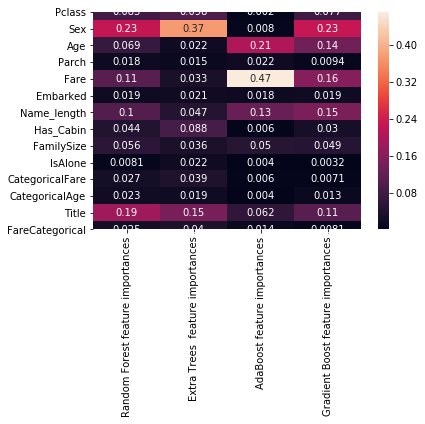

17. Créez une nouvelle colonne contenant la moyenne des feature importance pour chaque variable.

,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
Pclass,0.082746,0.097844,0.002,0.076993,0.064896
Sex,0.226313,0.374546,0.008,0.227004,0.208966
Age,0.068773,0.021553,0.206,0.137968,0.108573


# Second-Level Predictions from the First-level Output

**First-level output as new features**

18. Maintenant que nous avons nos prédictions du premier niveau, nous allons pouvoir entraîner notre modèle de niveau deux.
Commencez par former un data frame base_predictions_train qui contient les prédictions des base models pour x_train2 et un objet base_predictions_test qui contient les prédictions des base models pour x_test.

,RandomForest,ExtraTrees,AdaBoost,GradientBoost,svc
0,0.107125,0.123739,0.498664,0.000117,0.148962
1,0.976077,0.928762,0.503192,0.999993,0.828662
2,0.254063,0.279832,0.497129,0.000022,0.585541
3,0.970136,0.938981,0.502760,0.999980,0.853397
4,0.511087,0.534986,0.500356,0.000071,0.588587


,RandomForest,ExtraTrees,AdaBoost,GradientBoost,svc
0,0.097471,0.128183,0.498283,0.000024,0.130943
1,0.988973,0.948953,0.504257,0.999999,0.905423
2,0.052867,0.082310,0.497533,0.000073,0.096337
3,0.184920,0.202274,0.499137,0.000009,0.109307
4,0.075474,0.074362,0.493670,0.000014,0.074037


**Correlation Heatmap of the Second Level Training set**
19. Produisez une heatmap des corrélations entre les nouvelles variables


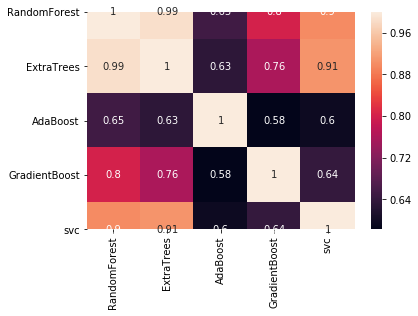

En général on préfère des modèles qui donnent des prédictions le moins corellées entre elles possible.

### Second level learning model via XGBoost

20. Créez une instance d'un modèle XGBoost XGBClassifier avec n_estimators= 2000, max_depth= 4 
Entraînez le sur vos nouvelles données de train et créez un objet predictions qui rassemblera les prédictions sur le test.

21. Quel est le score du modèle de niveau 2 ? Comment l'interprétez vous ? A quelles autres métriques pourrions nous le comparer?

0.9985955056179775

0.8491620111731844

0.8862359550561798

0.8324022346368715